# Training simple CNN to classify CIFAR10 dataset

The implementation of the CNN net is taken from the: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

According to that file:
```
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
```
When trained with single learning rate and RMSprop optimizer:
```
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
```
Here we do manual scheduling of learning rate and no data augmentation is used. The `std` normalized gradients optimizer reach 80% after only 20 epochs. After 45 epochs the final validation accuracy is 82%.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__

/media/data-disk/anaconda3/envs/adversarial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.7.0'

In [3]:
import sys
sys.path.append("../src/")
import keras_cifar_cnn as cnn
import tf_optimizer as tf_opt
import callbacks as clb
import utils as ut
from plotting import set_display_settings
set_display_settings()

from keras.optimizers import TFOptimizer
from keras.callbacks import History

Using TensorFlow backend.


## Dataset and model definition

In [4]:
x_train, y_train, validation_set, datagen = cnn.get_dataset()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
model = cnn.get_cnn()
batch_size = 32

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

# Train model with `AdaptiveNormalizedSGD`

Some notes: 

* `AdaptiveNormalizedSGD` is set to normalize gradients by their standard deviation.
* No momentum is used, since it did not improve results for this case.
* Adaptive learning rate is disabled. 

In [7]:
model = cnn.get_cnn()
metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001, 0.00001]:        
    # max norm was working fine but a little worse than Adam, I have tried std norm.
    #optimizer = TFOptimizer(tf_opt.LmaxNormalizedSGD(lr=lr))
    optimizer = TFOptimizer(tf_opt.AdaptiveNormalizedSGD(
        lr=lr, lr_update=0.0, momentum=0.0, momentum_update=0.00, norm_type='std'
    ))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 26s 520us/step - loss: 1.7508 - acc: 0.3597 - val_loss: 1.3766 - val_acc: 0.5064
Epoch 2/15
50000/50000 [==============================] - 20s 398us/step - loss: 1.3492 - acc: 0.5181 - val_loss: 1.2761 - val_acc: 0.5500
Epoch 3/15
50000/50000 [==============================] - 20s 391us/step - loss: 1.1380 - acc: 0.5992 - val_loss: 0.9663 - val_acc: 0.6656
Epoch 4/15
50000/50000 [==============================] - 19s 383us/step - loss: 1.0116 - acc: 0.6480 - val_loss: 0.9135 - val_acc: 0.6855
Epoch 5/15
50000/50000 [==============================] - 20s 394us/step - loss: 0.9288 - acc: 0.6764 - val_loss: 0.8056 - val_acc: 0.7222
Epoch 6/15
50000/50000 [==============================] - 20s 406us/step - loss: 0.8676 - acc: 0.6983 - val_loss: 0.7808 - val_acc: 0.7329
Epoch 7/15
50000/50000 [==============================] - 20s 395us/step - loss: 0.8201 - acc: 0.7172 - val_loss: 0.

50000/50000 [==============================] - 19s 384us/step - loss: 0.1731 - acc: 0.9389 - val_loss: 0.7125 - val_acc: 0.8178
Epoch 14/15
50000/50000 [==============================] - 19s 385us/step - loss: 0.1712 - acc: 0.9403 - val_loss: 0.7127 - val_acc: 0.8172
Epoch 15/15
50000/50000 [==============================] - 19s 383us/step - loss: 0.1730 - acc: 0.9395 - val_loss: 0.7124 - val_acc: 0.8184


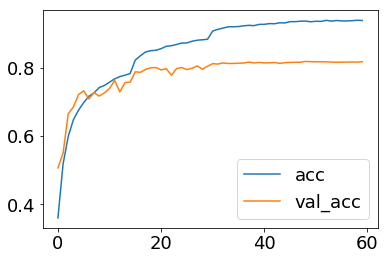

In [8]:
hist = metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with Adam optimizer

In [9]:
# Adam was not able to train with lr=0.005

In [10]:
from keras.optimizers import Adam, SGD

model = cnn.get_cnn()
adam_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.001, 0.0005, 0.0001]:    
    optimizer = Adam(lr=lr)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=adam_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 19s 381us/step - loss: 1.5678 - acc: 0.4284 - val_loss: 1.2270 - val_acc: 0.5554
Epoch 2/15
50000/50000 [==============================] - 18s 363us/step - loss: 1.1755 - acc: 0.5797 - val_loss: 0.9766 - val_acc: 0.6584
Epoch 3/15
50000/50000 [==============================] - 18s 355us/step - loss: 1.0058 - acc: 0.6465 - val_loss: 0.8849 - val_acc: 0.6858
Epoch 4/15
50000/50000 [==============================] - 18s 364us/step - loss: 0.9104 - acc: 0.6795 - val_loss: 0.8071 - val_acc: 0.7216
Epoch 5/15
50000/50000 [==============================] - 18s 362us/step - loss: 0.8452 - acc: 0.7043 - val_loss: 0.7832 - val_acc: 0.7248
Epoch 6/15
50000/50000 [==============================] - 18s 361us/step - loss: 0.7997 - acc: 0.7198 - val_loss: 0.7501 - val_acc: 0.7385
Epoch 7/15
50000/50000 [==============================] - 18s 361us/step - loss: 0.7607 - acc: 0.7336 - val_loss: 0.

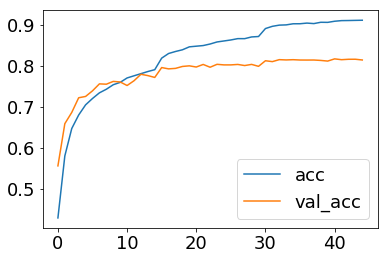

In [11]:
hist = adam_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Training with SGD and momentum=0.9

In [12]:
model = cnn.get_cnn()
momentum_metrics_history = [clb.AggregateMetricsOnBatchEnd(), clb.AggregateMetricsOnEpochEnd()]

for lr in [0.01, 0.005, 0.001]:    
    optimizer = SGD(lr=lr, momentum=0.9)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        x=x_train, y=y_train, batch_size=batch_size,
        epochs=15,
        validation_data=validation_set, 
        callbacks=momentum_metrics_history)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 17s 332us/step - loss: 1.8729 - acc: 0.3076 - val_loss: 1.5081 - val_acc: 0.4590
Epoch 2/15
50000/50000 [==============================] - 16s 310us/step - loss: 1.4264 - acc: 0.4833 - val_loss: 1.2022 - val_acc: 0.5673
Epoch 3/15
50000/50000 [==============================] - 16s 320us/step - loss: 1.2290 - acc: 0.5600 - val_loss: 1.1173 - val_acc: 0.6024
Epoch 4/15
50000/50000 [==============================] - 16s 310us/step - loss: 1.1059 - acc: 0.6079 - val_loss: 0.9602 - val_acc: 0.6564
Epoch 5/15
50000/50000 [==============================] - 16s 319us/step - loss: 1.0070 - acc: 0.6438 - val_loss: 0.9163 - val_acc: 0.6787
Epoch 6/15
50000/50000 [==============================] - 16s 316us/step - loss: 0.9504 - acc: 0.6665 - val_loss: 0.8470 - val_acc: 0.7015
Epoch 7/15
50000/50000 [==============================] - 16s 320us/step - loss: 0.8978 - acc: 0.6862 - val_loss: 0.

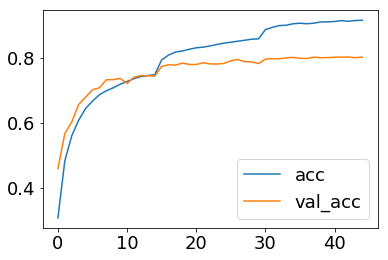

In [13]:
hist = momentum_metrics_history[1].monitor_values['accuracies']
for k, v in hist.items():
    if len(v) != 0: plt.plot(v, label=k)
plt.legend()

# Plots for comparison

In [14]:
hists = {
  'NSGD': metrics_history,
  'Adam': adam_metrics_history,
  'Momentum': momentum_metrics_history
} 

num_epochs = 45

Text(0,0.5,'training loss')

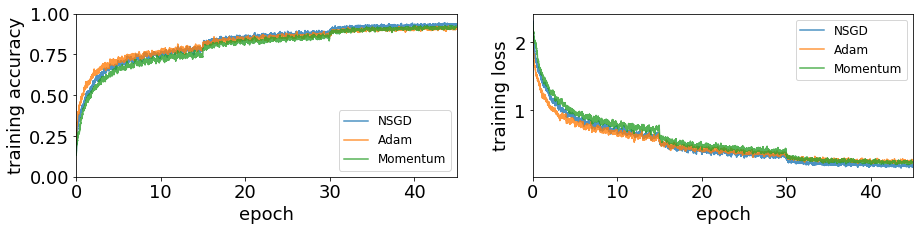

In [15]:
plt.figure(figsize=(15, 3))
plt.subplot(121)
for opt, hist in hists.items():
    h = hist[0].monitor_values['accuracies']['acc']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, len(h)/(50000/batch_size), len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[0].monitor_values['losses']['loss']
    h = ut.moving_average(h, periods=100)
    step_to_epoch = np.linspace(0, len(h)/(50000/batch_size), len(h))
    plt.plot(step_to_epoch, h, label=opt, alpha=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.xlim([0, num_epochs])
plt.xlabel('epoch')
plt.ylabel('training loss')
# plt.savefig('../img/cifar10_cnn_training.pdf')
# plt.savefig('../img/cifar10_cnn_training.png')

(0, 45)

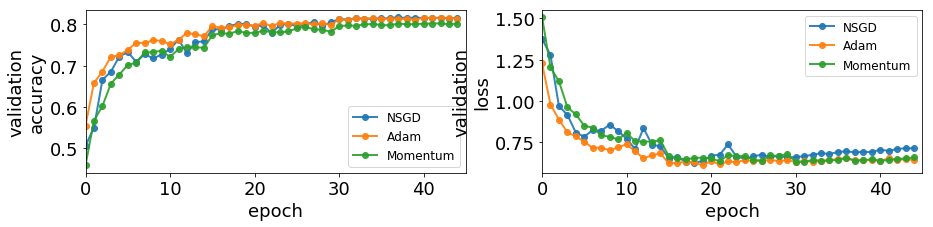

In [16]:
plt.figure(figsize=(15, 3))
plt.subplot(121)

for opt, hist in hists.items():
    h = hist[1].monitor_values['accuracies']['val_acc']
    plt.plot(h[:num_epochs], 'o-',label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel('epoch')
plt.ylabel('validation\naccuracy')
plt.xlim([0, num_epochs])

plt.subplot(122)
for opt, hist in hists.items():
    h = hist[1].monitor_values['losses']['val_loss']
    plt.plot(h[:num_epochs], 'o-', label=opt,  alpha=0.9, linewidth=2)
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('epoch')
plt.ylabel('validation\nloss')
plt.xlim([0, num_epochs])
# plt.savefig('../img/cifar10_cnn_validation.pdf')
# plt.savefig('../img/cifar10_cnn_validation.png')